# 2b. Supervised Model on Unseen Data

### Goal: Classify real-time tweets from blue-checkmarked Twitter accounts

Like the models trained on historical Tweets, we use list of terms correlated with road closures. The real time tweets are then classified and evaluated using the models trained on the historical tweets. To confrim the effectiveness of the models, we also generate predictions using the models and compare to the keyword classified target variable.

The real time tweets are taken from a curated list of traffic and weather reports from Jacksonville, FL.

- [**Import Libraries**](#Import-Libraries)
- [**EDA and Preprocessing**](#Exploratory-Data-Analysis-and-Preproccessing)
  - [Import Real Time Tweets](#Import-Real-Time-Tweets)
  - [Bar Plot](#Bar-Plot-Function)
  - [Regex Filter](#Regex-Text-Filter)
  - [Keyword Classification](#Keyword-Classification)
  - [Classification Evaluation](#Classification-Evaluation)
- [**Modeling**](#Modeling)
  - [Confusion Matrix Function](#Confusion-Matrix-Function)
  - [Regression Coefficient Plot Function](#Regression-Coefficient-Plot-Function)
  - [ROC AUC Plot Function](#ROC-AUC-Plot-Function)
  - [Logistic Regression with Count Vectorizor](#Logistic-Regression-with-Count-Vectorizor)
  - [TF-IDF Vectorizor and Gradient Boost](#TF-IDF-and-Gradient-Boosting)
- [**Modeling Unseen Data without Keyword Classification**](#Modeling-Unseen-Data-without-Keyword-Classification)
  - [Logistic Regression with Count Vectorizor](#Logistic-Regression-with-Count-Vectorizor)
  - [TF-IDF Vectorizor and Gradient Boost](#TF-IDF-and-Gradient-Boosting)
  - [Evaluation](#Evaluation)

## Import Libraries

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import re
import pickle

from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics
from sklearn.utils.multiclass import unique_labels
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_auc_score

pd.set_option('display.max_colwidth', -1)

## Exploratory Data Analysis and Preproccessing

#### Import Real Time Tweets

In [44]:
# import tweets
tweets = pd.read_csv("../data/Current_Tweets/RT_tweets_official_07312019.csv")

In [45]:
tweets.head()

date  geo hashtags                   id  \
0  2019-07-31 19:57:12 NaN   []       1156655067535224832   
1  2019-07-31 19:53:12 NaN   []       1156654059790712835   
2  2019-07-31 19:49:14 NaN   []       1156653061533851649   
3  2019-07-31 19:34:13 NaN   []       1156649282281332739   
4  2019-07-31 19:34:12 NaN   []       1156649281400520705   

                                                                                                                                          text  \
0  Updated: Disabled vehicle in Duval on I-295 E south at Dames Point, right lane blocked. Last updated at 03:56:35PM. https://t.co/qr0qEpEDg8   
1  Updated: Disabled vehicle in Duval on I-295 E south at Dames Point, 2 right lanes blocked. Last updated at...https://t.co/qr0qEpEDg8          
2  Updated: Disabled vehicle in Duval on I-295 E south at Dames Point, right lane blocked. Last updated at 03:48:15PM. https://t.co/qr0qEpEDg8   
3  Cleared: Planned construction in Duval on SR-105 / Heckscher Dr east at Imeson Park Blvd, right lane blocked. Last updated at 08:46:53AM.     
4  Cleared: Planned construction in Duval on SR-105 / Heckscher Dr west at Imeson Park Blvd, right lane blocked. Last updated at 08:48:11AM.     

       type         username  
0  official  fl511_northeast  
1  official  fl511_northeast  
2  official  fl511_northeast  
3  official  fl511_northeast  
4  official  fl511_northeast

In [46]:
# all tweets taken realtime will be from accounts that primarily report on
# traffic in jacksonville, fl, so state will be marked as Florida
accounts = tweets['username'].unique()
tweets['state'] = 'Florida'

#### Bar Plot Function

In [47]:
# define function to plot count of words after count vectorization
# Code modified from http://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
def bar_plot(x, y, title, color):    
    
    # Set up barplot 
    plt.figure(figsize=(8,4))
    ax = sns.barplot(x, y, color = color)

    # Label the graph
    plt.title(title, fontsize = 15)
    plt.xticks(fontsize = 10)

    # create a list to collect the plt.patches data
    totals = []

    # set individual bar lables using above list
    for p in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(p.get_width()+.3, p.get_y()+.38,
                int(p.get_width()), fontsize=10)

#### Regex Text Filter

In [48]:
# define function to run regex startments over a column labeled "text"
def twt_preprocess(twt):
    # run regex to remove urls
    twt['text'] = twt['text'].map(lambda x: re.sub(r"((http|ftp|https):\/\/)?[\w\-_]+(\.[\w\-_]+)+([\w\-\.,@?^=%&amp;:/~\+#]*[\w\-\@?^=%&amp;/~\+#])?", ' ', x))

    # run regex to remove non alphanumeric characters
    twt['text'] = twt['text'].map(lambda x: re.sub(r"[@\?\.$%_\!\[\]()+:;\/*\"]", ' ', x, flags=re.I))
    twt['text'] = twt['text'].map(lambda x: re.sub(r"[,']", '', x, flags=re.I))

    # run regex to remove common words
    twt['text'] = twt['text'].map(lambda x: re.sub('(twitter|tweet)[s]?', ' ', x,  flags=re.I))   
    

In [49]:
# run regex cleaner on full dataframe
twt_preprocess(tweets)

#### Keyword Classification

We use the same three lists of words to classify whether Tweets are about road closures.

In [50]:
# establish lists of words to search for in dataframe

# list of words having to do with roads
road_keywords = ['road', 'st', 'rd', 'hwy', 'highway', 'ave', 'avenue',
                 'intersection', 'bridge', 'sr-', 'cr-', 'us-', 'i-', 'blvd']

# list of words associated with road closures
closed_keywords = ['closed', 'remains closed', 'shut down', 'backed up',
                   'no travel', 'delay', 'blocked', 'delays',
                   'disabled', 'traffic', 'fire', 'flood', 'closures', 'closure']

# list of words that would generate false positives
to_drop = ["open", "opened", "lifted", "reopened", "clear", "cleared"]

In [51]:
# define function to filter the full dataframe for tweets that contain words from a keyword list
# modified code from arielle miro
def tweet_filter (df, col, keywords, roads, dropwords):
    
    # create a new column in the given dataframe
    # assign a value of 1 if any word in the text is in the keyword and road lists
    # assign a value of 0 if any word in the test is in the drop words list
    df['road_closure'] = df[col].map(lambda x: 1 if ((any(word in x for word in roads)) 
                                                     & (any(word in x for word in keywords)) 
                                                     & (not any(word in x for word in dropwords))) 
                                     else 0)   
    return df['road_closure']

In [52]:
# backup original tweet to new dataframe
tweets['tweet'] = tweets['text']

# make tweet text lowercase
tweets['text'] = tweets['text'].str.lower()

# run function on full dataframe
tweets['road_closure'] = tweet_filter(tweets, 'text', closed_keywords, road_keywords, to_drop)

In [53]:
# check shape and classification values of tweets
print(tweets.shape)
tweets['road_closure'].value_counts()

(200, 10)


1    125
0    75 
Name: road_closure, dtype: int64

## Classification Evaluation

In [54]:
# create a dataframe of only closures
closed = tweets[tweets['road_closure'] == 1]

In [55]:
# find which accounts had information about road closures
closed['username'].value_counts()

fl511_northeast    119
ActionTraffic      4  
JFRDJAX            2  
Name: username, dtype: int64

In [56]:
# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
cvec = cv.fit_transform(closed['text'])

# Convert cvec into a DataFrame
tweets_cvec = pd.DataFrame(cvec.toarray(),
                   columns=cv.get_feature_names())

# Inspect new DF
print(tweets_cvec.shape)

(125, 227)


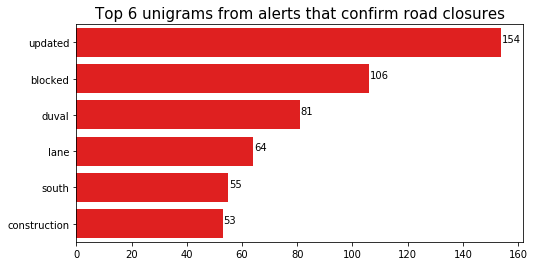

In [57]:
# Set up variables to contain top 5 most used words 
wc1_tweets_cvec = tweets_cvec.sum(axis = 0).sort_values(ascending=False).head(6)

# Call bar plot function
bar_plot(wc1_tweets_cvec.values, wc1_tweets_cvec.index, 'Top 6 unigrams from alerts that confirm road closures','r')

#### Create Dataframe of Tweets that do not mention closures

In [58]:
# Remove all road closure tweets from full dataframe
tweets_open = tweets[tweets['road_closure'] == 0]

# Shape
tweets_open.shape

(75, 10)

In [59]:
# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
cvec = cv.fit_transform(tweets_open['text'])

# Convert cvec into a DataFrame
tweets_cvec = pd.DataFrame(cvec.toarray(),
                   columns=cv.get_feature_names())

# Inspect new DF
print(tweets_cvec.shape)

(75, 331)


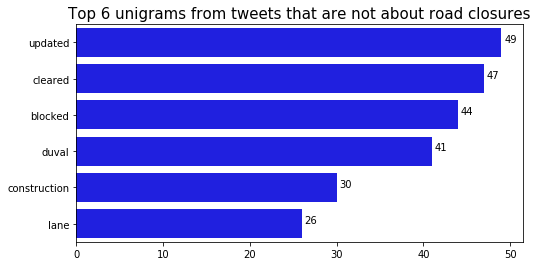

In [60]:
# Set up variables to contain top 5 most used words 
wc1_tweets_cvec = tweets_cvec.sum(axis = 0).sort_values(ascending=False).head(6)

# Call bar plot function
bar_plot(wc1_tweets_cvec.values, wc1_tweets_cvec.index, 'Top 6 unigrams from tweets that are not about road closures','b')

#### Create Training Dataframe

In [61]:
# copy dataframe
tweets_training = tweets
tweets_training.shape

(200, 10)

In [62]:
tweets_training.head()

date  geo hashtags                   id  \
0  2019-07-31 19:57:12 NaN   []       1156655067535224832   
1  2019-07-31 19:53:12 NaN   []       1156654059790712835   
2  2019-07-31 19:49:14 NaN   []       1156653061533851649   
3  2019-07-31 19:34:13 NaN   []       1156649282281332739   
4  2019-07-31 19:34:12 NaN   []       1156649281400520705   

                                                                                                                                       text  \
0  updated  disabled vehicle in duval on i-295 e south at dames point right lane blocked  last updated at 03 56 35pm                          
1  updated  disabled vehicle in duval on i-295 e south at dames point 2 right lanes blocked  last updated at                                  
2  updated  disabled vehicle in duval on i-295 e south at dames point right lane blocked  last updated at 03 48 15pm                          
3  cleared  planned construction in duval on sr-105   heckscher dr east at imeson park blvd right lane blocked  last updated at 08 46 53am    
4  cleared  planned construction in duval on sr-105   heckscher dr west at imeson park blvd right lane blocked  last updated at 08 48 11am    

       type         username    state  \
0  official  fl511_northeast  Florida   
1  official  fl511_northeast  Florida   
2  official  fl511_northeast  Florida   
3  official  fl511_northeast  Florida   
4  official  fl511_northeast  Florida   

                                                                                                                                      tweet  \
0  Updated  Disabled vehicle in Duval on I-295 E south at Dames Point right lane blocked  Last updated at 03 56 35PM                          
1  Updated  Disabled vehicle in Duval on I-295 E south at Dames Point 2 right lanes blocked  Last updated at                                  
2  Updated  Disabled vehicle in Duval on I-295 E south at Dames Point right lane blocked  Last updated at 03 48 15PM                          
3  Cleared  Planned construction in Duval on SR-105   Heckscher Dr east at Imeson Park Blvd right lane blocked  Last updated at 08 46 53AM    
4  Cleared  Planned construction in Duval on SR-105   Heckscher Dr west at Imeson Park Blvd right lane blocked  Last updated at 08 48 11AM    

   road_closure  
0  1             
1  1             
2  1             
3  0             
4  0

# Modeling

We run the same two models trained on the historical Tweets on the new, unseen, real time Tweets. We evaluate each model using a classification matrix and an ROC AUC curve.

In [63]:
# Baseline score
tweets_training['road_closure'].value_counts(normalize=True)

1    0.625
0    0.375
Name: road_closure, dtype: float64

In [64]:
# define our variables
X = tweets_training['text']
y = tweets_training['road_closure']

In [65]:
# train test split the data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = .3,
                                                    random_state=42,
                                                    stratify=y)

#### Confusion Matrix Function

In [66]:
# function to visualize confusion matrix
# Source code from SkLearn documentation
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

#### Regression Coefficient Plot Function

In [67]:
# function to plot regression coeficients for NLP models
# modified code from jasmine vasandani
def regression_coef_plot(pipe, e_name, v_name):
    # Create list of logistic regression coefficients 
    lr_coef = np.array(pipe.best_estimator_.named_steps[e_name].coef_).tolist()
    lr_coef = lr_coef[0]

    # create dataframe from lasso coef
    lr_coef = pd.DataFrame(np.round_(lr_coef, decimals=3), 
    pipe.best_estimator_.named_steps[v_name].get_feature_names(), columns = ["lr_coef"])

    # sort the values from high to low
    lr_coef = lr_coef.sort_values(by = 'lr_coef', 
    ascending = False)

    # Create top and bottom 10 
    df_head = lr_coef.head(10)
    df_tail = lr_coef.tail(10)

    # merge back together
    df_merged = pd.concat([df_head, df_tail], axis=0)

    # plot the sorted dataframe
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6)
    fig.suptitle('Coefficients', size=14)
    ax = sns.barplot(x = 'lr_coef', y= df_merged.index, 
    data=df_merged, palette= 'cubehelix')
    ax.set(xlabel='Regression Coefficients')
    plt.tight_layout(pad=3, w_pad=0, h_pad=0);

#### ROC AUC Plot Function

In [68]:
# helper functions for ROC AUC curve
# modified code from Arielle Miro

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))

In [69]:
# function to plot ROC AUC curve
# modified code from Tim Book
def roc_auc(X, y, estimator):
    
    # Create figure.
    plt.figure(figsize = (12,10))
    
    # calculate predicted probabilities
    pred_proba = [i[1] for i in estimator.predict_proba(X)]

    pred_df = pd.DataFrame({'true_values': y,
                            'pred_probs':pred_proba})

    # Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
    tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
    fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

    # Plot ROC curve.
    plt.plot(fpr_values, # False Positive Rate on X-axis
             tpr_values, # True Positive Rate on Y-axis
             label='ROC Curve')

    # Plot baseline. (Perfect overlap between the two populations.)
    plt.plot(np.linspace(0, 1, 200),
             np.linspace(0, 1, 200),
             label='baseline',
             linestyle='--')

    # Label axes.
    plt.title(f'ROC Curve with AUC = {roc_auc_score(y, estimator.predict(X))}', fontsize=22)
    plt.ylabel('Sensitivity', fontsize=18)
    plt.xlabel('1 - Specificity', fontsize=18)

    # Create legend.
    plt.legend(fontsize=16);

## Logistic Regression with Count Vectorizor

As with the historic tweets, this model scored very well due to keyword classification. The model did not score as highly as on the traning data, but was still very accurate

The model fit on training and testing split had an *r2* score of about 96.19% and 99.29%, ROC AUC of 93.77%, and minimal false positives.

In [70]:
# run pickled logisitic regression model

# load the model from disk
filename = '../data/Models/lr_cvec_07302019.sav'
lr = joblib.load(filename)

# Create the predictions for Y training data
y_pred = lr.predict(X_test)

print(f'Train Score: {lr.score(X_train, y_train)}')
print(f'Test Score: {lr.score(X_test, y_test)}')

Train Score: 0.9619755244755245
Test Score: 0.9929494712103408


Confusion matrix, without normalization
[[22  1]
 [ 3 34]]


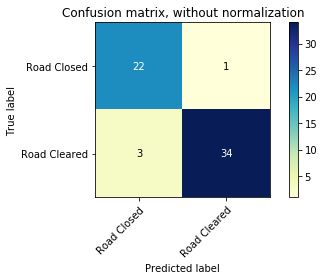

In [71]:
# set decimal places for numpy functions
np.set_printoptions(precision=2)

#define class names
class_names=np.array(['Road Closed', 'Road Cleared'])

# generate predictions
y_pred = lr.predict(X_test)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization',
                     cmap='YlGnBu')


plt.show();

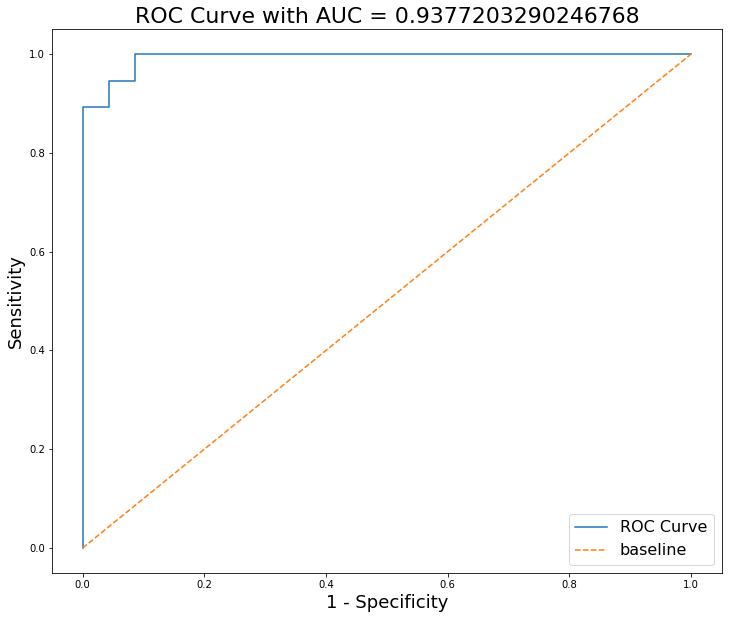

In [73]:
# run AUC ROC curve function
roc_auc(X_test, y_test, lr)

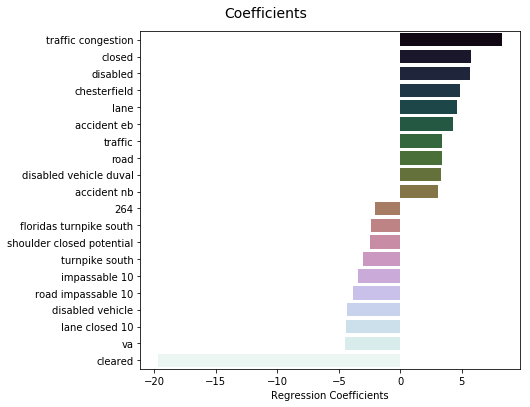

In [84]:
# run regression coefficient plot
# note: this data comes from being fit from the training data
# does not reflect the unseen data
regression_coef_plot(lr, 'lr', 'vec')

## TF-IDF and Gradient Boosting

Like with the Logistic Regression model, the TF-IDF Gradient Boosted classifier was not able to match the scores from the historical tweets, but still performed well.

The model fit on training and testing data had an *r2* score of about 96.8% and 98.82%, ROC AUC of 97.29%, and minimal false positives.

In [74]:
# run gradient pickled boosting classifier
# load the model from disk

filename = '../data/Models/gb_tvec_07302019.sav'
gb = joblib.load(filename)

# Create the predictions for Y training data
y_pred = gb.predict(X_test)

print(f'Train Score: {gb.score(X_train, y_train)}')
print(f'Test Score: {gb.score(X_test, y_test)}')

Train Score: 0.9688592657342657
Test Score: 0.9882491186839013


Confusion matrix, without normalization
[[23  0]
 [ 2 35]]


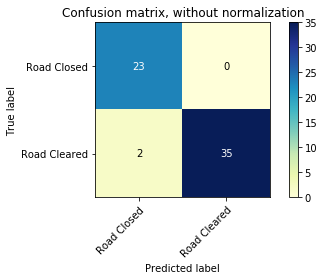

In [75]:
# generate predictions
y_pred = gb.predict(X_test)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization',
                     cmap='YlGnBu')


plt.show();

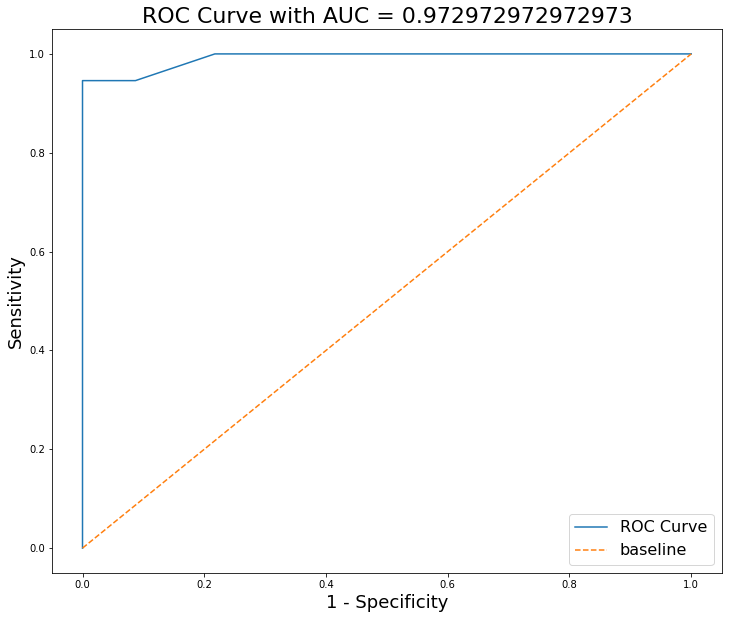

In [76]:
# run AUC ROC curve function
roc_auc(X_test, y_test, gb)

# Modeling Unseen Data without Keyword Classification

This was the true test for the efficacy of our models. We evaluated the models trained on the keyword classified historical tweets without a target `y` variable for scoring. This was then compared to the keyword classified models with using the generated classification matrices and ROC AUC.

The Gradient Boosted model only misclassified 7 tweets, while the Logistic Regression model misclassified 6. We then were able to look at the misclassified Tweets for tuning purposes.

Due to minimal false positives, this method could be used with streaming real time tweets for classification.

In [77]:
# define our variables
diff_df = tweets_training[['text', 'username', 'road_closure']]
diff_df['lr_pred'] = lr.predict(tweets['text'])
diff_df['gb_pred'] = gb.predict(tweets['text'])

C:\Users\templ\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\templ\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


## TF-IDF and Gradient Boosting

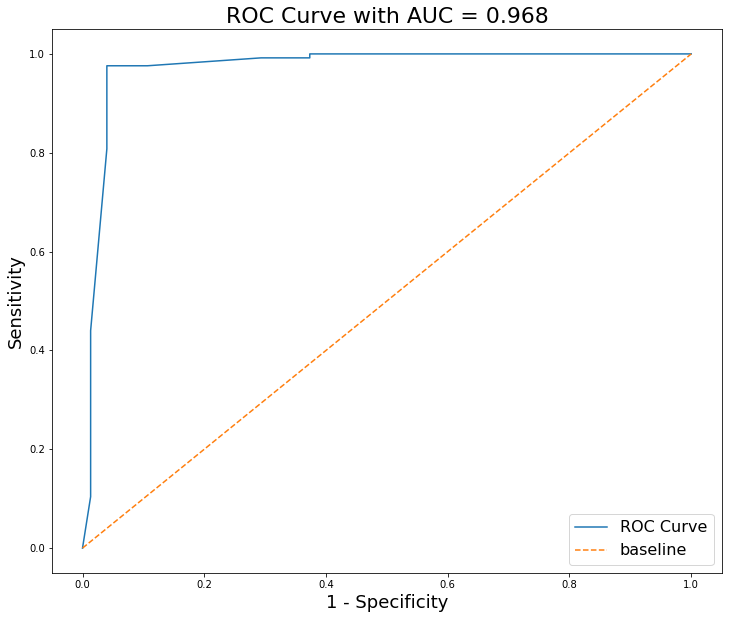

In [90]:
# ROC AUC for gradient boosted model
roc_auc(X, diff_df['road_closure'], gb)

Confusion matrix, without normalization
[[ 72   3]
 [  3 122]]


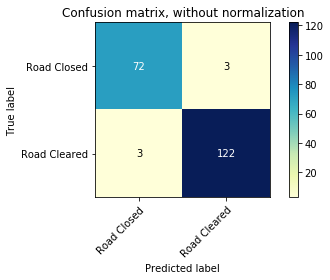

In [88]:
# Plot non-normalized confusion matrix for logistic regression model
plot_confusion_matrix(diff_df['gb_pred'], diff_df['road_closure'], classes=class_names,
                      title='Confusion matrix, without normalization',
                     cmap='YlGnBu')

## Logistic Regression with Count Vectorizor

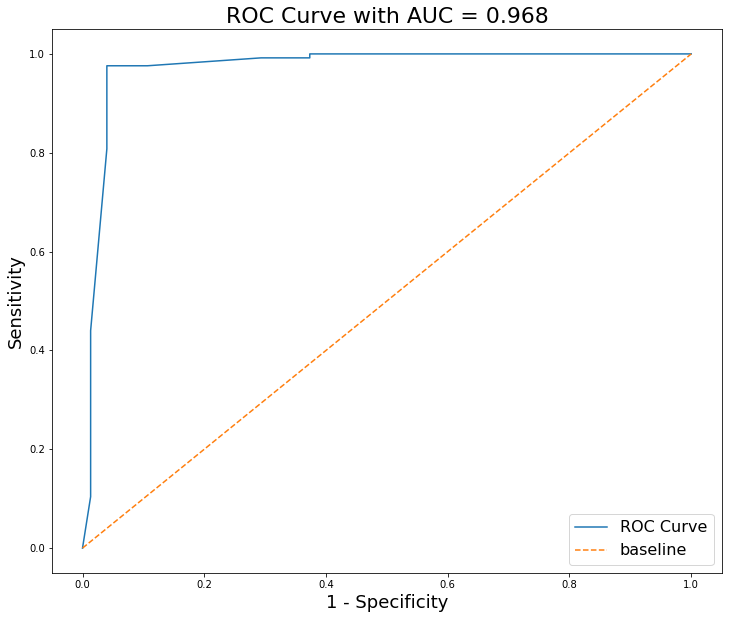

In [92]:
# ROC AUC for logistic regression model
roc_auc(X, diff_df['road_closure'], gb)

Confusion matrix, without normalization
[[ 68   3]
 [  7 122]]


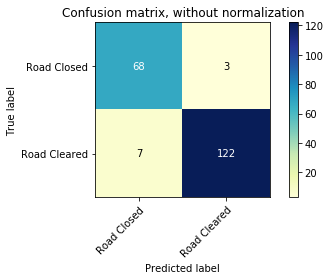

In [87]:
# Plot non-normalized confusion matrix for gradient boosted model
plot_confusion_matrix(diff_df['lr_pred'], diff_df['road_closure'], classes=class_names,
                      title='Confusion matrix, without normalization',
                     cmap='YlGnBu')

## Evaluation

Following the models' predictions, we observed which Tweets were misclassified.

#### False Positives

In [80]:
# looking at the Gradient Boost predictions, look at the tweets that were a false positive
diff_df[(diff_df['road_closure'] == 1) & (diff_df['gb_pred'] == 0)]

text  \
41   725a- big 3 travel times   i 10 starting to slow down #anjtraffic  actionnewsjax  wokvnews                                                     
52   rt  wxgarrett   actiontraffic is tracking a road closure for i-95 southbound near the st  johns county   flagler county line  tune into cbs…   
186  835a- big 3 travel times   delays linger on i 10 #anjtraffic  actionnewsjax                                                                    

          username  road_closure  lr_pred  gb_pred  
41   ActionTraffic  1             0        0        
52   ActionTraffic  1             1        0        
186  ActionTraffic  1             0        0

#### False Negatives

In [81]:
# looking at the Gradient Boost predictions, look at the tweets that were a false negative
diff_df[(diff_df['road_closure'] == 0) & (diff_df['gb_pred'] == 1)]

text  \
46   640a- update- 95 sb at us 1 bunnell exit    left lane now open  traffic still backed up about 2 miles #anjtraffic…      
55   507am- vehicle fire 95 sb at us 1 bunnell exit    sb lanes shut down and traffic being detoured #anjtraffic…            
198  735am- crash 95 sb after lem turner  right lanes blocked   expect heavy delays #anjtraffic  actionnewsjax  wokvnews     

          username  road_closure  lr_pred  gb_pred  
46   ActionTraffic  0             1        1        
55   ActionTraffic  0             1        1        
198  ActionTraffic  0             1        1

## Export Dataframe

In [94]:
tweets_training.head()

date  geo hashtags                   id  \
0  2019-07-31 19:57:12 NaN   []       1156655067535224832   
1  2019-07-31 19:53:12 NaN   []       1156654059790712835   
2  2019-07-31 19:49:14 NaN   []       1156653061533851649   
3  2019-07-31 19:34:13 NaN   []       1156649282281332739   
4  2019-07-31 19:34:12 NaN   []       1156649281400520705   

                                                                                                                                       text  \
0  updated  disabled vehicle in duval on i-295 e south at dames point right lane blocked  last updated at 03 56 35pm                          
1  updated  disabled vehicle in duval on i-295 e south at dames point 2 right lanes blocked  last updated at                                  
2  updated  disabled vehicle in duval on i-295 e south at dames point right lane blocked  last updated at 03 48 15pm                          
3  cleared  planned construction in duval on sr-105   heckscher dr east at imeson park blvd right lane blocked  last updated at 08 46 53am    
4  cleared  planned construction in duval on sr-105   heckscher dr west at imeson park blvd right lane blocked  last updated at 08 48 11am    

       type         username    state  \
0  official  fl511_northeast  Florida   
1  official  fl511_northeast  Florida   
2  official  fl511_northeast  Florida   
3  official  fl511_northeast  Florida   
4  official  fl511_northeast  Florida   

                                                                                                                                      tweet  \
0  Updated  Disabled vehicle in Duval on I-295 E south at Dames Point right lane blocked  Last updated at 03 56 35PM                          
1  Updated  Disabled vehicle in Duval on I-295 E south at Dames Point 2 right lanes blocked  Last updated at                                  
2  Updated  Disabled vehicle in Duval on I-295 E south at Dames Point right lane blocked  Last updated at 03 48 15PM                          
3  Cleared  Planned construction in Duval on SR-105   Heckscher Dr east at Imeson Park Blvd right lane blocked  Last updated at 08 46 53AM    
4  Cleared  Planned construction in Duval on SR-105   Heckscher Dr west at Imeson Park Blvd right lane blocked  Last updated at 08 48 11AM    

   road_closure  
0  1             
1  1             
2  1             
3  0             
4  0

In [83]:
tweets_training.to_csv('../data/cleaned_tweets/cleaned_RT_official_07312019.csv', index = False)